In [1]:
import pandas as pd
import datetime
from collections import Counter
import os

from spacy.cli import train_cli
from spacy.training.loop import train
from tqdm import tqdm
import shutil

In [2]:
final_financial_data_directory = 'final_financial_data'
final_financial_data_in_date_range_directory = 'final_financial_data_in_date_range'
final_financial_data_processed_17_variables_directory = 'final_financial_data_processed_17_variables'
final_financial_data_processed_100_variables_directory = 'final_financial_data_processed_100_variables'
final_financial_data_processed_17_variables_5years_directory = 'final_financial_data_processed_17_variables_5years'
final_financial_data_processed_17_variables_5years_version2_directory = 'final_financial_data_processed_17_variables_5years_version2'
final_financial_data_processed_17_variables_5years_version3_directory = 'final_financial_data_processed_17_variables_5years_version3'

In [3]:
eligible_companies = pd.read_csv('companies_eligible_to_financial_dataset_2024-04-19_14-47-55.csv')
eligible_companies.head()

,Unnamed: 0,cik,company,label,ticker,gurufocus-company-name,gurufocus-stockid,filing_date,cik-equal-gurufocus-cik,first_match
0,0,1800,ABBOTT LABORATORIES,False,ABT,Abbott Laboratories,US066X,2021-02-19,True,NaN
1,1,2488,ADVANCED MICRO DEVICES INC,False,AMD,Advanced Micro Devices Inc,US022E,2021-01-29,True,NaN
2,2,2491,"BALLY TECHNOLOGIES, INC.",False,BYI,Bally Technologies Inc (Delisted),US06R5,2014-08-29,True,NaN
3,3,2601,AEROFLEX INC,False,ARXX,Aeroflex Inc (Delisted),US026H,2006-09-13,True,NaN
4,4,2969,AIR PRODUCTS & CHEMICALS INC /DE/,False,APD,Air Products & Chemicals Inc,US06DU,2021-11-18,True,NaN


In [4]:
len(eligible_companies)

5417

In [4]:
eligible_companies['label'].value_counts()

label
False    5291
True      126
Name: count, dtype: int64

In [5]:
final_eligible_companies = eligible_companies.copy()

In [6]:
def drop_columns_after_ttm_or_preliminary(df):
    try:
        try:
            ttm_index = df.columns.get_loc('TTM')
            df = df.iloc[:, :ttm_index]
            return df
        except:
            pass
            
        try:
            ttm_preliminary_string = 'TTM  Preliminary'
            ttm_index = df.columns.get_loc(ttm_preliminary_string)
            df = df.iloc[:, :ttm_index]
            return df
        except:
            print(f'No \'TTM  Preliminary\' column in {filename}')
            
        try:
            preliminary_string = 'Preliminary'
            preliminary_index = None
            for i, s in enumerate(df.columns):
                if preliminary_string in s:
                    preliminary_index = i
                    break
                    
            df = df.iloc[:, :preliminary_index + 1]
            last_column_name = df.columns[-1]
            split_date = last_column_name.split(' ')
            updated_col_name = f'{split_date[0]} {split_date[1]}'
            
            df.rename(columns={last_column_name: updated_col_name}, inplace=True)
            
            print(f'No TTM but found Preliminary in {filename}')
        except:
            print(f'No Preliminary column in {filename}')
        
    except Exception as ex:
        print(f'Ex: {ex}, filename: {filename}')
    
    return df

def clean_date_index(df):
    for index in df.index:
        split_date = index.split(' ')
        month, year = split_date[0], int(split_date[1])
        
        if 0 <= year <= 9:
            year = f'200{year}'
        elif 10 <= year <= 24:
            year = f'20{year}'
        elif year > 24:
            year = f'19{year}'
            
        df.rename(index={index: f'{month} {year}'}, inplace=True)
    return df

In [7]:
def set_date_difference(final_eligible_companies):

    for index, row in final_eligible_companies.iterrows():
        try:
            cik = row['cik']
            gurufocus_stockid = row['gurufocus-stockid']
            ticker = row['ticker']
            filing_date = row['filing_date']
                
            filepath = f'{final_financial_data_directory}/{cik}-{gurufocus_stockid}_{ticker}.csv'
                
            df = pd.read_csv(filepath)
            
            df = drop_columns_after_ttm_or_preliminary(df)
            
            last_column_name = df.columns[-1]
            split_date = last_column_name.split(' ')
            month, year = split_date[0], int(split_date[1])
            
            if 0 <= year <= 9:
                year = f'200{year}'
            elif 10 <= year <= 24:
                year = f'20{year}'
            elif year > 24:
                year = f'19{year}'
                
            gurufocus_last_data_date = datetime.datetime.strptime(f'{month} {year}', '%b %Y')
            
            filing_date = filing_date[:7]
            filing_date = datetime.datetime.strptime(f'{filing_date}', '%Y-%m')
    
            difference_in_months = int((gurufocus_last_data_date - filing_date).days / 30)
            
            final_eligible_companies.loc[final_eligible_companies['cik'] == cik, 'difference_in_months'] = difference_in_months
        
        except Exception as ex:
            print(f'Ex: {ex}, filepath: {filepath}')
        
    return final_eligible_companies

In [8]:
final_eligible_companies = set_date_difference(final_eligible_companies)

Ex: invalid literal for int() with base 10: 'Period', filepath: final_financial_data/1766526-US26IG_TECTP.PFD.csv


In [9]:
counts_df = final_eligible_companies['difference_in_months'].value_counts()
# set column names
counts_df = counts_df.reset_index()
counts_df.columns = ['difference_in_months', 'count']
counts_df.head()

,difference_in_months,count
0,-3.0,1398
1,34.0,1190
2,-2.0,825
3,33.0,676
4,22.0,325


In [10]:
def get_companies_within_date_range(final_eligible_companies):
    mask = (final_eligible_companies['difference_in_months'] > -12) & (final_eligible_companies['difference_in_months'] < 36)
    eligible_companies_in_eligible_range = final_eligible_companies[mask]
    eligible_companies_in_eligible_range['difference_in_months'] = eligible_companies_in_eligible_range['difference_in_months'].astype(int)
    return eligible_companies_in_eligible_range

def drop_unused_columns(final_eligible_companies):
    final_eligible_companies.drop(columns=['cik-equal-gurufocus-cik', 'first_match'], inplace=True)
    return final_eligible_companies

#### Processing I

In [11]:
final_eligible_companies = get_companies_within_date_range(final_eligible_companies)
final_eligible_companies = drop_unused_columns(final_eligible_companies)

print(len(final_eligible_companies))
final_eligible_companies['label'].value_counts(normalize=True)

5078


C:\Users\grzeg\AppData\Local\Temp\ipykernel_5676\3847550151.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eligible_companies_in_eligible_range['difference_in_months'] = eligible_companies_in_eligible_range['difference_in_months'].astype(int)


label
False    0.976959
True     0.023041
Name: proportion, dtype: float64

In [45]:
# final_eligible_companies.to_csv('eligible_companies_in_eligible_range.csv', index=False)

#### Processing II - creating set of files with 17 variables (date range is different and depends on data, we will further process it to get 5 years of data)

In [21]:
final_eligible_companies = pd.read_csv('eligible_companies_in_eligible_range.csv')
len(final_eligible_companies)

5078

In [22]:
with open('chosen_variables.txt', 'r') as file:
    chosen_variables = file.read().splitlines()
    
with open('most_common_variables.txt', 'r') as file:
    most_common_variables = file.read().splitlines()

In [23]:
def delete_duplicated_rows(df):
    df.drop(df.index[df.iloc[:, 0].duplicated(keep=False)], inplace=True)
    return df

def has_dataframe_enough_variables(df, variables, threshold):
    csv_variable = df.iloc[:, 0].tolist()
    lacking_variables = []
    for variable in variables:
        if variable not in csv_variable:
            lacking_variables.append(variable)
            
    if len(lacking_variables) <= threshold:
        return True, lacking_variables
    else:
        return False, lacking_variables
    
def enrich_filename_with_label(filename, label):
    filename = filename.replace('.csv', '')
    filename = f'{filename}_{label}.csv'
    return filename

In [25]:
max_lacking_variables_threshold_chosen_variables = 3
missing_value = 0
all_cells = 0

filenames = os.listdir(final_financial_data_in_date_range_directory)

for filename in tqdm(filenames):
    try:
        cik = int(filename.split('-')[0])
        df = pd.read_csv(f'{final_financial_data_in_date_range_directory}/{filename}')
        
        df.drop(df.columns[0], axis=1, inplace=True)
        
        df = drop_columns_after_ttm_or_preliminary(df)
        
        df = delete_duplicated_rows(df)
        
        has_enough_variables, lacking_variables = has_dataframe_enough_variables(df, chosen_variables, max_lacking_variables_threshold_chosen_variables)
        # if has_enough_variables is False:
        #     final_eligible_companies.loc[final_eligible_companies['cik'] == cik, 'has_enough_variables'] = False
        #     continue
        
        df.set_index(df.columns[0], inplace=True)
        
        df = df[df.index.isin(chosen_variables)]
        
        df = df.T
        df = df.replace('-', pd.NA)
        df = df.replace('', pd.NA)
        # df.fillna(method='bfill', inplace=True)
        # df.fillna(method='ffill', inplace=True)
        # df.fillna(0, inplace=True)
        
        # insert missing variables as whole columns with 0
        if len(lacking_variables) > 0:
            for variable in lacking_variables:
                df[variable] = pd.NA
                
        df = clean_date_index(df)
        
        df = df.reindex(sorted(df.columns), axis=1)
        
        label = final_eligible_companies.loc[final_eligible_companies['cik'] == cik]['label'].values[0]
        
        df.to_csv(f'{final_financial_data_processed_17_variables_directory}/{enrich_filename_with_label(filename, label)}', index=True, index_label='Fiscal Period')
        
        
        final_eligible_companies.loc[final_eligible_companies['cik'] == cik, 'has_enough_variables'] = has_enough_variables
        
        all_cells += len(df) * len(chosen_variables)
        missing_value += df.isnull().sum().sum()
        
    except Exception as ex:
        print(f'Ex: {ex}, filename: {filename}')   

100%|██████████| 5078/5078 [00:33<00:00, 153.19it/s]


In [26]:
print(f'missing_value: {missing_value}')
print(f'missing ratio: {missing_value/all_cells}')

missing_value: 357408
missing ratio: 0.3362118595279217


In [28]:
final_eligible_companies['has_enough_variables'].value_counts()

has_enough_variables
True     3777
False    1301
Name: count, dtype: int64

#### Here we can create two version of the dataset: with less than 3 lacking variables or with, but we will stick to one with more lacking variables

In [165]:
# final_eligible_companies_with_enough_variables = final_eligible_companies[final_eligible_companies['has_enough_variables'] == True]

In [29]:
final_eligible_companies.drop(columns=['has_enough_variables'], inplace=True)

In [30]:
final_eligible_companies.to_csv('eligible_companies_in_eligible_range_with_all_variables.csv', index=False)

In [32]:
final_eligible_companies['label'].value_counts()

label
False    4961
True      117
Name: count, dtype: int64

In [4]:
csv_lengths = []
for filename in os.listdir(final_financial_data_processed_17_variables_directory):
    df = pd.read_csv(f'{final_financial_data_processed_17_variables_directory}/{filename}')
    
    # if len(df) > 17:
    #     print(f'Error in {filename}')
    csv_lengths.append(len(df))

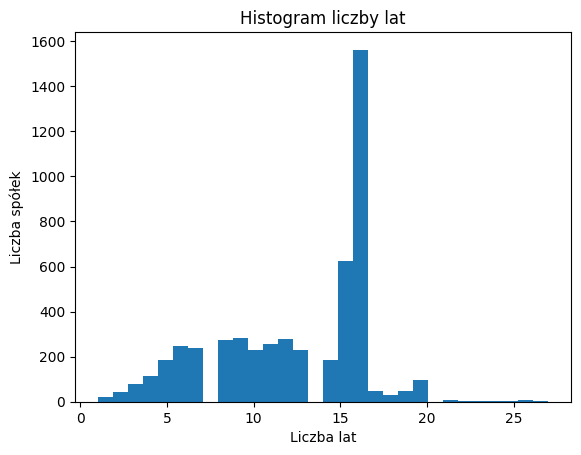

In [6]:
import matplotlib.pyplot as plt

plt.hist(csv_lengths, bins=30)
plt.title('Histogram liczby lat')
plt.xlabel('Liczba lat')
plt.ylabel('Liczba spółek')
plt.show()

In [44]:
csv_lengths_counter = Counter(csv_lengths)
csv_lengths_counter

Counter({16: 1562,
         15: 624,
         9: 283,
         12: 277,
         8: 273,
         11: 256,
         6: 248,
         7: 238,
         13: 231,
         10: 230,
         14: 184,
         5: 184,
         4: 112,
         20: 96,
         3: 77,
         19: 47,
         17: 46,
         2: 43,
         18: 28,
         1: 19,
         26: 7,
         21: 7,
         23: 2,
         22: 1,
         27: 1,
         24: 1,
         25: 1})

In [50]:
less_than_5_count = 0
for val, cnt in csv_lengths_counter.items():
    if val < 5:
        less_than_5_count += cnt

less_than_5_count

251

#### csv data extra validation

In [36]:
for filename in os.listdir(final_financial_data_processed_17_variables_directory):
    df = pd.read_csv(f'{final_financial_data_processed_17_variables_directory}/{filename}', index_col='Fiscal Period')
    
    column_headers = df.columns.tolist()
    
    if len(column_headers) != len(chosen_variables):
        print(f'Error in {filename}')

#### Getting variables within x years from bankruptcy

In [54]:
ecl_dataset = pd.read_csv('ECL_with_ticker_2024-04-19_14-35-21.csv')

C:\Users\grzeg\AppData\Local\Temp\ipykernel_5676\1756588558.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  ecl_dataset = pd.read_csv('ECL_with_ticker_2024-04-19_14-35-21.csv')


In [55]:
ecl_dataset_grouped = ecl_dataset.groupby('cik').agg({'bankruptcy_date_1': 'first', 'bankruptcy_date_2': 'first', 'bankruptcy_date_3': 'first','ticker': 'first', 'label': 'last', 'cik-equal-gurufocus-cik': 'last', 'filing_date': 'last'}).reset_index()
ecl_dataset_grouped['is_bankruptcy_date_filled'] = ecl_dataset_grouped['bankruptcy_date_1'].notnull()
ecl_dataset_grouped['is_bankruptcy_date_filled'].value_counts()

is_bankruptcy_date_filled
False    8252
True      891
Name: count, dtype: int64

In [56]:
ecl_dataset_grouped_eligible = ecl_dataset_grouped[ecl_dataset_grouped['cik-equal-gurufocus-cik'] == True]
len(ecl_dataset_grouped_eligible)

5417

In [57]:
ecl_dataset_grouped_eligible.head()

,cik,bankruptcy_date_1,bankruptcy_date_2,bankruptcy_date_3,ticker,label,cik-equal-gurufocus-cik,filing_date,is_bankruptcy_date_filled
1,1800,None,None,None,ABT,False,True,2021-02-19,False
6,2488,None,None,None,AMD,False,True,2021-01-29,False
7,2491,None,None,None,BYI,False,True,2014-08-29,False
8,2601,None,None,None,ARXX,False,True,2006-09-13,False
10,2969,None,None,None,APD,False,True,2021-11-18,False


In [58]:
def is_date_valid(value):
  try:
    date = pd.to_datetime(value)
    if pd.isnull(date):
      return False
    return True
  except (pd.errors.OutOfBoundsDatetime, ValueError):
    return False

In [60]:
index_to_have_minimal_years_threshold = 5

eligible_companies_with_minimal_years_count = 0
no_date_found = 0

for filename in os.listdir(final_financial_data_processed_17_variables_directory):
    try:
        df = pd.read_csv(f'{final_financial_data_processed_17_variables_directory}/{filename}', index_col='Fiscal Period')
        
        cik = int(filename.split('-')[0])
        label = bool(filename.split('_')[2].split('.')[0])
        
        bankruptcies = ecl_dataset.loc[ecl_dataset['cik'] == cik][['bankruptcy_date_1', 'bankruptcy_date_2', 'bankruptcy_date_3']]
    
        if is_date_valid(bankruptcies['bankruptcy_date_3'].values[0]):
            last_datetime = bankruptcies['bankruptcy_date_3'].values[0]
        elif is_date_valid(bankruptcies['bankruptcy_date_2'].values[0]):
            last_datetime = bankruptcies['bankruptcy_date_2'].values[0]
        elif is_date_valid(bankruptcies['bankruptcy_date_1'].values[0]):
            last_datetime = bankruptcies['bankruptcy_date_1'].values[0]
        else:
            last_datetime = ecl_dataset_grouped_eligible.loc[ecl_dataset_grouped_eligible['cik'] == cik]['filing_date'].values[0]
            
        last_datetime = last_datetime[:7]
        last_datetime = datetime.datetime.strptime(last_datetime, '%Y-%m')
        
        indexes_as_datetime = [datetime.datetime.strptime(f'{index}', '%b %Y') for index in df.index]
            
        found = False
        for i, date in reversed(list(enumerate(indexes_as_datetime))):
            if date <= last_datetime:
                corresponding_last_date = date
                
                if i >= index_to_have_minimal_years_threshold - 1:
                    df = df.iloc[i-index_to_have_minimal_years_threshold+1:i + 1]
                    eligible_companies_with_minimal_years_count += 1
                    df.to_csv(f'{final_financial_data_processed_17_variables_5years_version3_directory}/{filename}', index=True, index_label='Fiscal Period')
                    ecl_dataset_grouped_eligible.loc[ecl_dataset_grouped_eligible['cik'] == cik, 'has_minimal_years'] = True
                    
                    found = True
                break

        if found is False:
            no_date_found += 1
                
    except Exception as ex:
        print(f'Ex: {ex}, filename: {filename}')

C:\Users\grzeg\AppData\Local\Temp\ipykernel_5676\362105922.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecl_dataset_grouped_eligible.loc[ecl_dataset_grouped_eligible['cik'] == cik, 'has_minimal_years'] = True


In [61]:
print(f'no_date_found: {no_date_found}')

no_date_found: 523


In [62]:
eligible_companies_with_minimal_years_count

4555

In [63]:
ecl_dataset_grouped_eligible_with_minimal_years = ecl_dataset_grouped_eligible[ecl_dataset_grouped_eligible['has_minimal_years'] == True]

len(ecl_dataset_grouped_eligible_with_minimal_years)

4555

# Dataset for 17 variables exists, with data from 5 years - could be used for training model

In [64]:
# TODO later: save with filename to report - match by bankruptcy or filing date !!!
# TODO: plot labels distribution
ecl_dataset_grouped_eligible_with_minimal_years.to_csv('ecl_dataset_grouped_eligible_with_minimal_years_missing_data.csv', index=False)

In [70]:
bankrupt_companies_with_17_variables_5_years = pd.DataFrame()

for i, filename in enumerate(os.listdir(final_financial_data_processed_17_variables_5years_version3_directory)):
    try:
        df = pd.read_csv(f'{final_financial_data_processed_17_variables_5years_version3_directory}/{filename}', index_col='Fiscal Period')
        
        for column in df.columns:
            df[column] = df[column].astype(str).str.replace('M', '*1e6', regex=False).str.replace('B', '*1e9', regex=False)
        
            df[column] = pd.to_numeric(df[column].apply(lambda x: pd.eval(x) if x.replace('.', '', 1).isdigit() else x), errors='coerce')
        
            df[column] = df[column].astype(float)
        
        filename_without_extension = filename.replace('.csv', '')
        
        label = filename_without_extension.split('_')[-1]

        mapping = {'True': True, 'False': False}
        label = mapping[label]
        
        df.reset_index(inplace=True)
        df.insert(loc=0, column='cik', value=int(filename.split('-')[0]))
        df.insert(loc=1, column='ticker', value=filename.split('_')[1])
        df.insert(loc=2, column='label', value=label)

        bankrupt_companies_with_17_variables_5_years = pd.concat([bankrupt_companies_with_17_variables_5_years, df])
        
    except Exception as ex:
        print(f'Ex: {ex}, filename: {filename}')

In [ ]:
bankrupt_companies_with_17_variables_5_years.sort_values(by=['cik', 'Fiscal Period'], inplace=True)
bankrupt_companies_with_17_variables_5_years.to_csv('bankrupt_companies_with_17_variables_5_years_version3.csv', index=False)

In [71]:
bankrupt_companies_with_17_variables_5_years.head()

,cik,ticker,label,Fiscal Period,Cost of Goods Sold,"Depreciation, Depletion and Amortization",EBIT,EBITDA,Gross Profit,Long-Term Debt,...,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
0,1800,ABT,False,Dec 2016,9094.0,1353.0,1844.0,3197.0,11759.0,20681.0,...,1400.0,25565.0,20853.0,52666.0,26776.0,6660.0,2434.0,31949.0,8733.0,5054.0
1,1800,ABT,False,Dec 2017,12409.0,3021.0,3135.0,6156.0,14981.0,27210.0,...,477.0,23978.0,27390.0,76250.0,20147.0,8912.0,3601.0,45152.0,13417.0,6916.0
2,1800,ABT,False,Dec 2018,12706.0,3278.0,3699.0,6977.0,17872.0,19359.0,...,2368.0,24560.0,30578.0,67173.0,14632.0,9012.0,3796.0,36451.0,14222.0,6750.0
3,1800,ABT,False,Dec 2019,13231.0,3014.0,4747.0,7761.0,18673.0,16661.0,...,3687.0,25847.0,31904.0,67887.0,15667.0,10863.0,4316.0,36586.0,14141.0,7211.0
4,1800,ABT,False,Dec 2020,15003.0,3327.0,5514.0,8841.0,19605.0,18527.0,...,4495.0,27627.0,34608.0,72548.0,20441.0,11907.0,5012.0,39545.0,14248.0,8281.0


In [73]:
# bankrupt_companies_with_17_variables_5_years = pd.read_csv('bankrupt_companies_with_17_variables_5_years.csv')

bankrupt_companies_with_17_variables_5_years_grouped = bankrupt_companies_with_17_variables_5_years.groupby('cik').agg({'label': 'first'}).reset_index()

bankrupt_companies_with_17_variables_5_years_grouped['label'].value_counts()

label
False    4460
True       95
Name: count, dtype: int64

In [75]:
bankrupt_companies_with_17_variables_5_years_grouped.head()

,cik,label
0,1800,False
1,2488,False
2,2491,False
3,2969,False
4,3153,False


In [74]:
number_of_companies = len(bankrupt_companies_with_17_variables_5_years_grouped)
number_of_companies

4555

## Official splitting data process (in 2 versions: for full dataset and for original dataset - below) 

In [5]:
# this is valid - good file without duplicates, but with missing values
bankrupt_companies_with_17_variables_5_years = pd.read_csv('bankrupt_companies_with_17variables_5years_split_version5_complete.csv')
bankrupt_companies_with_17_variables_5_years = bankrupt_companies_with_17_variables_5_years.drop('subset', axis=1)
# remove rows that have empty ticker
bankrupt_companies_with_17_variables_5_years = bankrupt_companies_with_17_variables_5_years[~bankrupt_companies_with_17_variables_5_years['ticker'].isna()]
len(bankrupt_companies_with_17_variables_5_years)/5, len(bankrupt_companies_with_17_variables_5_years['cik'].unique())

(4466.0, 4466)

In [6]:
bankrupt_companies_with_17_variables_5_years.head()

,cik,ticker,label,Fiscal Period,Cost of Goods Sold,"Depreciation, Depletion and Amortization",EBIT,EBITDA,Gross Profit,Long-Term Debt,...,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
0,737874,LI,False,Aug 2002,479.0,281.0,1028.0,1310.0,4004.0,1145.0,...,-1223.0,-10.0,4483.0,3853.0,948.0,695.0,50.0,2562.0,3829.0,570.0
1,737874,LI,False,Aug 2003,479.0,281.0,1028.0,1310.0,4004.0,1145.0,...,-1223.0,-10.0,4483.0,3853.0,948.0,695.0,50.0,2562.0,3829.0,570.0
2,737874,LI,False,Aug 2004,483.0,284.0,224.0,507.0,4149.0,1114.0,...,62.0,52.0,4631.0,3905.0,1032.0,687.0,51.0,2529.0,3928.0,588.0
3,737874,LI,False,Aug 2005,579.0,249.0,63.0,312.0,2447.0,287.0,...,212.0,249.0,3027.0,2909.0,606.0,448.0,33.0,1309.0,2282.0,203.0
4,737874,LI,False,Aug 2006,582.0,216.0,261.0,477.0,2550.0,773.0,...,125.0,315.0,3132.0,3039.0,741.0,531.0,41.0,1831.0,2299.0,211.0


In [7]:
bankrupt_companies_with_17_variables_5_years['label'].value_counts()

label
False    21960
True       370
Name: count, dtype: int64

In [8]:
def flatten_financial_dataset(financial_dataset):
    object_length_in_rows = 5
    metadata_columns_length = 4
    per_object_columns = list(financial_dataset.columns[:metadata_columns_length].values)
    
    value_columns = financial_dataset.columns[metadata_columns_length:]
    new_columns = per_object_columns + [f'{col}_{i+1}' for i in range(object_length_in_rows) for col in value_columns]
    
    dfs = []
    
    for i in range(0, len(financial_dataset), object_length_in_rows):
        group = financial_dataset.iloc[i:i + object_length_in_rows]
        if len(group) < object_length_in_rows:
            break
    
        name = group['cik'].iloc[0]
        ticker = group['ticker'].iloc[0]
        label = group['label'].iloc[0]
        fiscal_periods = ';'.join(group['Fiscal Period'].astype(str).values)
    
        values = group.drop(columns=per_object_columns).values.flatten()
        
        dfs.append([name, ticker, label, fiscal_periods] + values.tolist())
    
    final_flatten_df = pd.DataFrame(dfs, columns=new_columns)
    final_flatten_df = final_flatten_df.reset_index(drop=True)
    return final_flatten_df

def deflatten_financial_dataset(flatten_df):
    object_length_in_rows = 5
    info_columns_count = 5

    values_columns = flatten_df.columns[info_columns_count:]
    unique_values_columns = sorted(set(col.split('_')[0] for col in values_columns))
    
    new_columns = flatten_df.columns[:info_columns_count].tolist() + unique_values_columns

    deflattened_rows = []

    for _, row in flatten_df.iterrows():
        first_columns = row.values[:info_columns_count]
        fiscal_periods = row.values[4].split(';')
        if fiscal_periods[0] == '':
            fiscal_periods = ['' for _ in range(object_length_in_rows)]
        
        reshaped_values = np.array(row.values[info_columns_count:]).reshape(object_length_in_rows, -1)
        
        try:
            for i in range(object_length_in_rows):
                new_row = np.concatenate([first_columns[:4], [fiscal_periods[i]], reshaped_values[i]])
                deflattened_rows.append(new_row)
                
        except Exception as ex:
            print(f'Ex: {ex}, row: {row["cik"]}')

    deflatten_df = pd.DataFrame(deflattened_rows, columns=new_columns)
    
    return deflatten_df.reset_index(drop=True)

#### Function for splitting data into train, val and test subset that should be unseen for model and that's why will be very small

In [19]:
from imblearn.over_sampling import SMOTE
import numpy as np
import math

def split_dataset(
        df,
        test_subset_samples_ratio=0.15,
        val_subset_samples_ratio=0.05,
        oversample_with_SMOTE=True,
        match_with_synthetic_textual_data=False,
        synthetic_textual_data_filepath='synthetic_textual_data.csv',
        shuffle=False,
        shuffle_seed=42):
    
    flatten_df = flatten_financial_dataset(df)
    
    if shuffle:
        flatten_df = flatten_df.sample(frac=1, random_state=shuffle_seed).reset_index(drop=True)
        
    flatten_df.insert(loc=3, column='subset', value='train')
    
    df_true = flatten_df[flatten_df['label'] == True]
    df_false = flatten_df[flatten_df['label'] == False]
    
    sampling_strategy = 0.0
    synthetic_textual_data_len = 0
    positive_count_train = math.ceil(len(df_true) * (1 - (test_subset_samples_ratio + val_subset_samples_ratio)))
    
    if oversample_with_SMOTE:
        sampling_strategy = 1.0
            
        if match_with_synthetic_textual_data:
            synthetic_textual_data = pd.read_csv(synthetic_textual_data_filepath)
            synthetic_textual_data_len = len(synthetic_textual_data)
            
            negative_count = len(df_false)
            
            all_samples_after_smote_without_true_val_and_test = synthetic_textual_data_len + positive_count_train + negative_count
            val_test_samples_false_count = int((all_samples_after_smote_without_true_val_and_test) * (test_subset_samples_ratio + val_subset_samples_ratio))
            train_samples_count = all_samples_after_smote_without_true_val_and_test - val_test_samples_false_count
            train_samples_count_without_smote = train_samples_count - synthetic_textual_data_len
            
            sampling_strategy = (synthetic_textual_data_len + positive_count_train)/(train_samples_count_without_smote - positive_count_train)
            # ss = (text_count + pos_count) / neg_count
            sampling_strategy = math.ceil(sampling_strategy * 10000) / 10000
    
            print(f"Sampling strategy: {sampling_strategy}")
    
    # true label
    df_true_test_len = int(len(df_true) * test_subset_samples_ratio)
    df_true_test = df_true[:df_true_test_len]
    
    df_true_train_and_val = df_true[df_true_test_len:]
    
    df_true_val_len = int(len(df_true) * val_subset_samples_ratio)
    df_true_val = df_true_train_and_val[:df_true_val_len]
    
    # false label
    df_false_test_len = int((len(df_false) + synthetic_textual_data_len + positive_count_train) * test_subset_samples_ratio)
    df_false_test = df_false[:df_false_test_len]
    
    df_false_train_and_val = df_false[df_false_test_len:]
    
    df_false_val_len = int((len(df_false) + synthetic_textual_data_len + positive_count_train) * val_subset_samples_ratio)
    df_false_val = df_false_train_and_val[:df_false_val_len]
    
    df_test = pd.concat([df_true_test, df_false_test])
    df_test['subset'] = 'test'
    
    df_val = pd.concat([df_true_val, df_false_val])
    df_val['subset'] = 'val'
    
    df_train = pd.concat([df_true_train_and_val[df_true_val_len:], df_false_train_and_val[df_false_val_len:]])
    
    if oversample_with_SMOTE:
        df_train_X = df_train.drop(columns=['cik', 'label', 'subset', 'ticker', 'Fiscal Period'])
        y = df_train['label'].values
        smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy)
        X_resampled, y_resampled = smote.fit_resample(df_train_X, y)
        
        X_resampled_positive = X_resampled[y_resampled == True]
        X_original_positive = df_train_X[y == True]
        
        df1_set = set(X_resampled_positive.to_records(index=False).tolist())
        df2_set = set(X_original_positive.to_records(index=False).tolist())
        
        X_resampled_positive_generated = pd.DataFrame.from_records(list(df1_set.difference(df2_set)))
        X_resampled_positive_generated.columns = df_train_X.columns
        
        for col in X_resampled_positive_generated.columns:
            X_resampled_positive_generated[col] = X_resampled_positive_generated[col].astype(int)
            X_resampled_positive_generated[col] = X_resampled_positive_generated[col].astype(np.float64)
            
        if match_with_synthetic_textual_data:
            synthetic_ciks = synthetic_textual_data['cik'].values
            X_resampled_positive_generated['cik'] = synthetic_ciks
        else:  
            X_resampled_positive_generated['cik'] = 'synthetic'
            
        X_resampled_positive_generated['ticker'] = ''
        X_resampled_positive_generated['label'] = True
        X_resampled_positive_generated['Fiscal Period'] = ''
        X_resampled_positive_generated['subset'] = 'train'
        
        X_resampled_positive_generated = X_resampled_positive_generated[['cik', 'ticker', 'label', 'subset', 'Fiscal Period'] + df_train_X.columns.tolist()]
        # X_resampled_positive_generated.to_csv(f'synthetic_financial_positive_data_version_2-{str(datetime.datetime.now())[:10]}.csv', index=False)
        
        df_train = pd.concat([df_train, X_resampled_positive_generated])
    
    print(len(df_train), len(df_val), len(df_test))
    
    full_df = pd.concat([df_train, df_val, df_test])
    if shuffle:
        full_df = full_df.sample(frac=1, random_state=shuffle_seed).reset_index(drop=True)
        
    full_df_deflatten = deflatten_financial_dataset(full_df)
    
    full_df_deflatten.to_csv(f'bankrupt_companies_with_17variables_5years_split_version5_original_{str(datetime.datetime.now())[:10]}.csv', index=False)
    
    return full_df_deflatten

In [27]:
# fill Nan values with backfill and forward fill and then with 0
bankrupt_companies_with_17_variables_5_years.fillna(method='bfill', inplace=True)
bankrupt_companies_with_17_variables_5_years.fillna(method='ffill', inplace=True)
bankrupt_companies_with_17_variables_5_years.fillna(0, inplace=True)

bankrupt_companies_with_17_variables_5_years.isnull().sum().sum()

0

In [28]:
bankrupt_companies_with_17_variables_5_years['label'].value_counts()

label
False    21960
True       370
Name: count, dtype: int64

In [25]:
# import math
# bankrupt_companies_with_17_variables_5_years_flatten = flatten_financial_dataset(bankrupt_companies_with_17_variables_5_years)
# flatten_df = bankrupt_companies_with_17_variables_5_years_flatten.copy()
# 
# test_subset_samples_ratio = 0.15
# val_subset_samples_ratio = 0.05
# oversample_with_SMOTE = True
# match_with_synthetic_textual_data = True
# synthetic_textual_data_filepath = 'synthetic_textual_data.csv'
# shuffle = False
# shuffle_seed = 42
# 
# # flatten_df = flatten_financial_dataset(df)
# 
# if shuffle:
#     flatten_df = flatten_df.sample(frac=1, random_state=shuffle_seed).reset_index(drop=True)
#     
# flatten_df.insert(loc=3, column='subset', value='train')
# 
# df_true = flatten_df[flatten_df['label'] == True]
# df_false = flatten_df[flatten_df['label'] == False]
# 
# sampling_strategy = 0.0
# synthetic_textual_data_len = 0
# 
# if oversample_with_SMOTE:
#     sampling_strategy = 1.0
#         
#     if match_with_synthetic_textual_data:
#         synthetic_textual_data = pd.read_csv(synthetic_textual_data_filepath)
#         synthetic_textual_data_len = len(synthetic_textual_data)
#         
#         positive_count_train = math.ceil(len(df_true) * (1 - (test_subset_samples_ratio + val_subset_samples_ratio)))
#         negative_count = len(df_false)
#         
#         all_samples_after_smote_without_true_val_and_test = synthetic_textual_data_len + positive_count_train + negative_count
#         val_test_samples_false_count = int((all_samples_after_smote_without_true_val_and_test) * (test_subset_samples_ratio + val_subset_samples_ratio))
#         train_samples_count = all_samples_after_smote_without_true_val_and_test - val_test_samples_false_count
#         train_samples_count_without_smote = train_samples_count - synthetic_textual_data_len
#         
#         sampling_strategy = (synthetic_textual_data_len + positive_count_train)/(train_samples_count_without_smote - positive_count_train)
#         # ss = (text_count + pos_count) / neg_count
#         sampling_strategy = math.ceil(sampling_strategy * 10000) / 10000
#         samples_to_be_generated_count = int(train_samples_count_without_smote * sampling_strategy)
# 
#         print(f"Sampling strategy: {sampling_strategy}")
# 
# # true label
# df_true_test_len = int(len(df_true) * test_subset_samples_ratio)
# df_true_test = df_true[:df_true_test_len]
# 
# df_true_train_and_val = df_true[df_true_test_len:]
# 
# df_true_val_len = int(len(df_true) * val_subset_samples_ratio)
# df_true_val = df_true_train_and_val[:df_true_val_len]
# 
# # false label
# df_false_test_len = int((len(df_false) + synthetic_textual_data_len + positive_count_train) * test_subset_samples_ratio)
# df_false_test = df_false[:df_false_test_len]
# 
# df_false_train_and_val = df_false[df_false_test_len:]
# 
# df_false_val_len = int((len(df_false) + synthetic_textual_data_len + positive_count_train) * val_subset_samples_ratio)
# df_false_val = df_false_train_and_val[:df_false_val_len]
# 
# df_test = pd.concat([df_true_test, df_false_test])
# df_test['subset'] = 'test'
# 
# df_val = pd.concat([df_true_val, df_false_val])
# df_val['subset'] = 'val'
# 
# df_train = pd.concat([df_true_train_and_val[df_true_val_len:], df_false_train_and_val[df_false_val_len:]])
# 
# if oversample_with_SMOTE:
#     df_train_X = df_train.drop(columns=['cik', 'label', 'subset', 'ticker', 'Fiscal Period'])
#     y = df_train['label'].values
#     smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy)
#     X_resampled, y_resampled = smote.fit_resample(df_train_X, y)
#     
#     X_resampled_positive = X_resampled[y_resampled == True]
#     X_original_positive = df_train_X[y == True]
#     
#     df1_set = set(X_resampled_positive.to_records(index=False).tolist())
#     df2_set = set(X_original_positive.to_records(index=False).tolist())
#     
#     X_resampled_positive_generated = pd.DataFrame.from_records(list(df1_set.difference(df2_set)))
#     X_resampled_positive_generated.columns = df_train_X.columns
#     
#     for col in X_resampled_positive_generated.columns:
#         X_resampled_positive_generated[col] = X_resampled_positive_generated[col].astype(int)
#         X_resampled_positive_generated[col] = X_resampled_positive_generated[col].astype(np.float64)
#         
#     if match_with_synthetic_textual_data:
#         synthetic_ciks = synthetic_textual_data['cik'].values
#         X_resampled_positive_generated['cik'] = synthetic_ciks
#     else:  
#         X_resampled_positive_generated['cik'] = 'synthetic'
#         
#     X_resampled_positive_generated['ticker'] = ''
#     X_resampled_positive_generated['label'] = True
#     X_resampled_positive_generated['Fiscal Period'] = ''
#     X_resampled_positive_generated['subset'] = 'train'
#     
#     X_resampled_positive_generated = X_resampled_positive_generated[['cik', 'ticker', 'label', 'subset', 'Fiscal Period'] + df_train_X.columns.tolist()]
#     # X_resampled_positive_generated.to_csv(f'synthetic_financial_positive_data_version_2-{str(datetime.datetime.now())[:10]}.csv', index=False)
#     
#     df_train = pd.concat([df_train, X_resampled_positive_generated])
# 
# print(len(df_train), len(df_val), len(df_test))
# 
# full_df = pd.concat([df_train, df_val, df_test])
# if shuffle:
#     full_df = full_df.sample(frac=1, random_state=shuffle_seed).reset_index(drop=True)
#     
# full_df_deflatten = deflatten_financial_dataset(full_df)
# 
# full_df_deflatten.to_csv(f'bankrupt_companies_with_17variables_5years_split_version5_{str(datetime.datetime.now())[:10]}.csv', index=False)
# full_df_deflatten = deflatten_financial_dataset(full_df)
# print(len(df_train), len(df_val), len(df_test))

Sampling strategy: 0.9513
5760 363 1091
5760 363 1091


In [29]:
full_df = split_dataset(
    bankrupt_companies_with_17_variables_5_years,
    test_subset_samples_ratio=0.15,
    val_subset_samples_ratio=0.05,
    oversample_with_SMOTE=True,
    match_with_synthetic_textual_data=True,
    shuffle=True,
    shuffle_seed=42)

full_df.head()

Sampling strategy: 0.9513
5760 363 1091


,cik,ticker,label,subset,Fiscal Period,Cost of Goods Sold,"Depreciation, Depletion and Amortization",EBIT,EBITDA,Gross Profit,...,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
0,737874,LI,False,train,Aug 2002,479.0,281.0,1028.0,1310.0,4004.0,...,-1223.0,-10.0,4483.0,3853.0,948.0,695.0,50.0,2562.0,3829.0,570.0
1,737874,LI,False,train,Aug 2003,479.0,281.0,1028.0,1310.0,4004.0,...,-1223.0,-10.0,4483.0,3853.0,948.0,695.0,50.0,2562.0,3829.0,570.0
2,737874,LI,False,train,Aug 2004,483.0,284.0,224.0,507.0,4149.0,...,62.0,52.0,4631.0,3905.0,1032.0,687.0,51.0,2529.0,3928.0,588.0
3,737874,LI,False,train,Aug 2005,579.0,249.0,63.0,312.0,2447.0,...,212.0,249.0,3027.0,2909.0,606.0,448.0,33.0,1309.0,2282.0,203.0
4,737874,LI,False,train,Aug 2006,582.0,216.0,261.0,477.0,2550.0,...,125.0,315.0,3132.0,3039.0,741.0,531.0,41.0,1831.0,2299.0,211.0


In [32]:
full_df['subset'].value_counts(normalize=True)

subset
train    0.798447
test     0.151234
val      0.050319
Name: proportion, dtype: float64

In [33]:
df_bankrupt_companies_complete_split = pd.read_csv('bankrupt_companies_with_17variables_5years_split_version5_2024-09-18.csv')
len(df_bankrupt_companies_complete_split)/5, len(df_bankrupt_companies_complete_split['cik'].unique())

(7214.0, 7214)

In [34]:
full_df['label'].value_counts()

label
False    21960
True     14110
Name: count, dtype: int64

In [35]:
full_df['subset'].value_counts(normalize=True)

subset
train    0.798447
test     0.151234
val      0.050319
Name: proportion, dtype: float64

In [36]:
full_df_grouped = full_df.groupby('cik').agg({'label': 'first', 'subset': 'first', 'ticker': 'first'})
full_df_grouped['label'].value_counts()

label
False    4392
True     2822
Name: count, dtype: int64

Getting number of objects with 'true' label in each subset

In [38]:
df_bankrupt_companies_complete_split[(df_bankrupt_companies_complete_split['label'] == True) & ~(df_bankrupt_companies_complete_split['ticker'].isna())]['subset'].value_counts()

subset
train    300
test      55
val       15
Name: count, dtype: int64

### Getting textual data for companies

In [39]:
unique_ciks_for_orig_companies = df_bankrupt_companies_complete_split[~df_bankrupt_companies_complete_split['ticker'].isna()]['cik'].unique()
len(unique_ciks_for_orig_companies)

4466

In [40]:
summarized_mda_sections_for_eligible_companies_in_range_directory = 'summarized_mda_sections_for_eligible_companies_in_range'

In [41]:
filenames = os.listdir(summarized_mda_sections_for_eligible_companies_in_range_directory)

textual_data_ciks = []

for filename in tqdm(filenames):
    cik = int(filename.split('-')[0])
    textual_data_ciks.append(cik)

100%|██████████| 4947/4947 [00:00<?, ?it/s]


In [42]:
not_present_ciks = []

for cik in unique_ciks_for_orig_companies:
    if cik not in textual_data_ciks:
        not_present_ciks.append(cik)
len(not_present_ciks)

0

In [43]:
df_bankrupt_companies_complete = df_bankrupt_companies_complete_split[~df_bankrupt_companies_complete_split['cik'].isin(not_present_ciks)]
len(df_bankrupt_companies_complete)/5

7214.0

In [44]:
df_bankrupt_companies_complete.to_csv('bankrupt_companies_with_17variables_5years_split_version5_complete.csv', index=False)

### Version for original dataset

In [20]:
# this is valid - good file without duplicates, but with missing values
bankrupt_companies_with_17_variables_5_years = pd.read_csv('bankrupt_companies_with_17variables_5years_split_version5_complete.csv')
bankrupt_companies_with_17_variables_5_years = bankrupt_companies_with_17_variables_5_years.drop('subset', axis=1)
# remove rows that have empty ticker
bankrupt_companies_with_17_variables_5_years_original = bankrupt_companies_with_17_variables_5_years[~bankrupt_companies_with_17_variables_5_years['ticker'].isna()]
len(bankrupt_companies_with_17_variables_5_years_original)/5, len(bankrupt_companies_with_17_variables_5_years_original['cik'].unique())

(4466.0, 4466)

In [21]:
bankrupt_companies_with_17_variables_5_years_original.fillna(method='bfill', inplace=True)
bankrupt_companies_with_17_variables_5_years_original.fillna(method='ffill', inplace=True)
bankrupt_companies_with_17_variables_5_years_original.fillna(0, inplace=True)

bankrupt_companies_with_17_variables_5_years_original.isnull().sum().sum()

C:\Users\grzeg\AppData\Local\Temp\ipykernel_6724\1335980064.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bankrupt_companies_with_17_variables_5_years_original.fillna(method='bfill', inplace=True)
C:\Users\grzeg\AppData\Local\Temp\ipykernel_6724\1335980064.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bankrupt_companies_with_17_variables_5_years_original.fillna(method='ffill', inplace=True)
C:\Users\grzeg\AppData\Local\Temp\ipykernel_6724\1335980064.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.or

0

In [22]:
full_df_original = split_dataset(
    bankrupt_companies_with_17_variables_5_years_original,
    test_subset_samples_ratio=0.15,
    val_subset_samples_ratio=0.05,
    oversample_with_SMOTE=False,
    match_with_synthetic_textual_data=False,
    shuffle=True,
    shuffle_seed=42)

full_df_original.head()

3563 225 678


,cik,ticker,label,subset,Fiscal Period,Cost of Goods Sold,"Depreciation, Depletion and Amortization",EBIT,EBITDA,Gross Profit,...,Net Income,Retained Earnings,Revenue,Total Assets,Total Current Assets,Total Current Liabilities,Total Inventories,Total Liabilities,Total Operating Expense,Total Receivables
0,103096,TRR,False,train,Jun 2012,246.5,5.5,30.0,35.5,56.2,...,33.6,-113.7,302.7,275.1,154.0,117.6,77.1,207.3,26.2,96.2
1,103096,TRR,False,train,Jun 2013,268.5,6.9,18.6,25.5,56.6,...,36.3,-77.4,325.2,307.8,185.3,123.7,77.1,201.2,38.0,110.8
2,103096,TRR,False,train,Jun 2014,312.1,8.8,20.9,29.7,60.8,...,12.1,-65.4,372.9,335.6,221.0,132.2,77.1,211.1,39.9,160.0
3,103096,TRR,False,train,Jun 2015,337.3,9.3,30.7,40.0,77.4,...,19.4,-45.9,414.6,362.9,234.3,144.2,77.1,215.4,46.6,179.7
4,103096,TRR,False,train,Jun 2016,402.3,14.7,2.2,16.9,79.0,...,0.0,-45.9,481.3,478.5,248.2,178.4,77.1,325.1,77.7,199.3


In [23]:
full_df_original['subset'].value_counts(normalize=True)

subset
train    0.797806
test     0.151814
val      0.050381
Name: proportion, dtype: float64

In [26]:
full_df_original.drop_duplicates(subset=['cik'])['label'].value_counts(normalize=True)

label
False    0.98343
True     0.01657
Name: proportion, dtype: float64

In [27]:
full_df_original.to_csv('bankrupt_companies_with_17variables_5years_split_version5_original.csv', index=False)

### matching with textual data (already matched with synthetic textual data)

In [45]:
unique_ciks_from_matched_data = df_bankrupt_companies_complete[~df_bankrupt_companies_complete['ticker'].isna()]['cik'].unique()
len(unique_ciks_from_matched_data)

4466

In [46]:
import re

def clean_markdown(text):
    markdown_chars = ["*", "_", "#", "~", "`", ">", "=", "[", "]"]
    text = re.sub(f"[{re.escape(''.join(markdown_chars))}]", "", text)
    text = re.sub(r"\n", " ", text)
    
    return text

import string
def preprocess_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.digits))
    return text

In [47]:
textual_data = pd.DataFrame(columns=['cik', 'text'])

for filename in os.listdir(summarized_mda_sections_for_eligible_companies_in_range_directory):
    cik = int(filename.split('-')[0])
    if cik not in unique_ciks_from_matched_data:
        continue
        
    with open(f'{summarized_mda_sections_for_eligible_companies_in_range_directory}/{filename}', 'r') as file:
        text = file.read()
        
        text = clean_markdown(text)
        
        textual_data = pd.concat([textual_data, pd.DataFrame([{'cik': cik, 'text': text}])], ignore_index=True)
        
textual_data.to_csv(f'textual_data_original_matched_with_fin_data_version2.csv', index=False)
print(len(textual_data))
textual_data.head()

4466


,cik,text
0,1000180,The company is a global leader in NAND flash s...
1,1000209,The company is transitioning from medallion le...
2,1000228,"The company, Henry Schein, is the world's larg..."
3,1000235,Patriot Bank Corp. went public in 1995 and has...
4,1000694,Novavax is a clinical-stage biotechnology comp...


In [36]:
textual_data = pd.read_csv('textual_data_version6_complete.csv')
textual_data_original = textual_data[~textual_data['ticker'].isna()]
synthetic_textual_data = pd.read_csv('synthetic_textual_data.csv')
len(synthetic_textual_data), len(textual_data_original)

(2748, 4466)

In [48]:
# all_textual_data = pd.concat([textual_data, synthetic_textual_data])
all_textual_data = textual_data_original
all_textual_data.drop(columns=['label', 'subset'], inplace=True)
# len(all_textual_data)
all_textual_data.head()

C:\Users\grzeg\AppData\Local\Temp\ipykernel_6724\1557381661.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_textual_data.drop(columns=['label', 'subset'], inplace=True)


,cik,ticker,report_datetime,text
0,737874,LI,2005-11-14,Laidlaw International Inc. is a leading provid...
1,1464343,ATLC,2020-03-30,The company utilizes proprietary analytics and...
3,1022368,SHF,2001-08-29,The company experienced net income (loss) fluc...
4,815094,ABMD,2020-05-21,The company is a leading provider of temporary...
5,1159297,MWV,2014-02-24,MeadWestvaco reported a 2% increase in sales a...


In [38]:
df_bankrupt_companies_complete = pd.read_csv('bankrupt_companies_with_17variables_5years_split_version5_original.csv')
df_bankrupt_companies_unique = df_bankrupt_companies_complete.drop_duplicates(subset=['cik'])
len(df_bankrupt_companies_unique)

4466

In [49]:
df_bankrupt_companies_complete[~df_bankrupt_companies_complete['ticker'].isna()]['label'].value_counts()

label
False    21960
True       370
Name: count, dtype: int64

In [50]:
(21960+370)/5

4466.0

In [51]:
df_bankrupt_companies_unique = df_bankrupt_companies_unique[['cik', 'label', 'subset']]
df_bankrupt_companies_unique.head()

,cik,label,subset
0,103096,False,train
5,752642,False,train
10,846930,False,train
15,354190,False,train
20,1135017,False,train


In [52]:
# add to the textual data the labels and subsets
all_textual_data_enriched = pd.merge(df_bankrupt_companies_unique, all_textual_data, on='cik')
all_textual_data_enriched = all_textual_data_enriched[['cik', 'ticker', 'label', 'subset', 'report_datetime', 'text']]
all_textual_data_enriched.head()

,cik,ticker,label,subset,report_datetime,text
0,103096,TRR,False,train,2015-09-09,Summary of Management Discussion and Analysis...
1,752642,UMH,False,train,2020-03-05,UMH increased rental and related income by 13%...
2,846930,DQE,False,train,2006-03-07,The company's strategy is focused on its core ...
3,354190,AJG,False,train,2020-02-07,Summary of Management's Discussion and Analys...
4,1135017,KMR,False,train,2013-02-21,"Kinder Morgan Management, LLC (KMR) manages an..."


In [54]:
all_textual_data_enriched.to_csv('textual_data_matched_split_version6_original.csv', index=False)

In [55]:
all_textual_data_enriched = pd.read_csv('textual_data_matched_split_version6_original.csv')
all_textual_data_enriched.head()

,cik,ticker,label,subset,report_datetime,text
0,103096,TRR,False,train,2015-09-09,Summary of Management Discussion and Analysis...
1,752642,UMH,False,train,2020-03-05,UMH increased rental and related income by 13%...
2,846930,DQE,False,train,2006-03-07,The company's strategy is focused on its core ...
3,354190,AJG,False,train,2020-02-07,Summary of Management's Discussion and Analys...
4,1135017,KMR,False,train,2013-02-21,"Kinder Morgan Management, LLC (KMR) manages an..."


In [59]:
def match_textual_data_with_financial_data(textual_dataset, financial_dataset):
    financial_dataset_ciks = financial_dataset['cik'].unique()
    
    textual_dataset_copy = textual_dataset.copy()
    textual_dataset_copy['cik'] = pd.Categorical(textual_dataset_copy['cik'], categories=financial_dataset_ciks, ordered=True)
    textual_dataset_copy = textual_dataset_copy.sort_values('cik').reset_index(drop=True)
    
    assert financial_dataset_ciks.tolist() == textual_dataset_copy['cik'].tolist()
    
    return textual_dataset_copy

In [60]:
df_bankrupt_companies_complete = pd.read_csv('bankrupt_companies_with_17variables_5years_split_version5_original.csv')

In [61]:
all_textual_data_enriched = match_textual_data_with_financial_data(all_textual_data_enriched, df_bankrupt_companies_complete)
all_textual_data_enriched.head()

,cik,ticker,label,subset,report_datetime,text
0,103096,TRR,False,train,2015-09-09,Summary of Management Discussion and Analysis...
1,752642,UMH,False,train,2020-03-05,UMH increased rental and related income by 13%...
2,846930,DQE,False,train,2006-03-07,The company's strategy is focused on its core ...
3,354190,AJG,False,train,2020-02-07,Summary of Management's Discussion and Analys...
4,1135017,KMR,False,train,2013-02-21,"Kinder Morgan Management, LLC (KMR) manages an..."


In [62]:
all_textual_data_enriched.to_csv('textual_data_matched_split_version6_original.csv', index=False)

In [63]:
len(all_textual_data_enriched)

4466

In [66]:
all_textual_data_enriched[all_textual_data_enriched['subset'] == 'test']['label'].value_counts(normalize=True)

label
False    0.983776
True     0.016224
Name: proportion, dtype: float64